In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d

In [2]:
def lotkavolterra(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    b_curr = b(R_curr, T_curr)
    print(f'b = {b_curr}')
    print(' ')
    print(f'mu = {mu_curr}')
    print(f'muM = {mu_curr * M}')
    
    b = B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    mu = -log(1 / (np.exp(-0.03 * T_curr ** 2 + 1.31 * T_curr - 4.4)))
    M = 300000

    b = mu * M
    
    #dShdt = -a_curr * b2 * (I_M / N) * S_H
    #dIhdt = a_curr * b2 * (I_M(t - tau_H) / N) * S_H(t - tau_H) - gamma * I_H
    #dRhdt = gamma * I_H
    
    #dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu * S_M
    #dEmdt = a_curr * b1 * (I_H / N) * S_M - mu * E_M - a * b1 * (I_H(t - tau_H) / N) * S_M(t - tau_H) * l_tau_M
    #dImdt = a * b1 * (I_H(t - tau_H) / N) * S_M(t - tau_H) * l_tau_M - mu * I_M
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [3]:
T1=27.4
T2=0.025
omega1=0.02
phi1=1.53
R1=196.9
R2=0.033
omega2=0.025
phi2=1.99

B_E=200
p_ME=0.9
p_ML=0.25
p_MP=0.75
tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737
D1=36.5
b1=0.1
A=-0.03
B=1.31
C=-4.4
b2=0.3
tau_H=10
DD=105
Tmin=14.5
gamma= 1/1095 #1/365
R_L = 50
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = -202213.71530243798
 
mu = 0.1115841612302408
muM = 33475.24836907224
b = -202213.734407367
 
mu = 0.11158416212099352
muM = 33475.248636298056
b = -202213.81579470355
 
mu = 0.11158416591561372
muM = 33475.24977468412
b = -202213.86604088222
 
mu = 0.11158416825830063
muM = 33475.25047749019
b = -202213.94141020748
 
mu = 0.1115841717723313
muM = 33475.25153169939
b = -202214.25339380017
 
mu = 0.11158418631827303
muM = 33475.25589548191
b = -202214.35213578658
 
mu = 0.11158419092201598
muM = 33475.257276604796
b = -202214.19292698774
 
mu = 0.11158418349906829
muM = 33475.25504972049
b = -202214.30314843112
 
mu = 0.11158418863803188
muM = 33475.25659140956
b = -202214.95958141735
 
mu = 0.11158421924343973
muM = 33475.26577303192
b = -202214.86160601256
 
mu = 0.11158421467546556
muM = 33475.26440263967
b = -202215.3528838594
 
mu = 0.11158423758060249
muM = 33475.27127418075
b = -202215.6258172629
 
mu = 0.11158425030568915
muM = 33475.275091706746
b = -202215.6258172629
 
mu 

muM = 32791.120923018076
b = -187508.98990957392
 
mu = 0.11055581089110793
muM = 33166.74326733238
b = -184369.6253437936
 
mu = 0.11038444234640812
muM = 33115.33270392244
b = -172201.16437440837
 
mu = 0.10954551181417607
muM = 32863.65354425282
b = -170181.8816284395
 
mu = 0.1092538087584725
muM = 32776.14262754175
b = -170118.90115428471
 
mu = 0.10922992027981537
muM = 32768.97608394461
b = -170067.15396599672
 
mu = 0.10919544358971801
muM = 32758.633076915405
b = -170397.5764353305
 
mu = 0.10907030222590317
muM = 32721.09066777095
b = -170684.40899841278
 
mu = 0.10903667907440612
muM = 32711.003722321835
b = -170265.10789982032
 
mu = 0.10909232236396343
muM = 32727.69670918903
b = -170531.186343043
 
mu = 0.10905299689443601
muM = 32715.899068330804
b = -174353.26546742462
 
mu = 0.10889459940157606
muM = 32668.37982047282
b = -173542.31069036576
 
mu = 0.10890990189842312
muM = 32672.970569526937
b = -178435.31951640447
 
mu = 0.1088629614326369
muM = 32658.888429791074
b 

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 281
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff1814c250>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

In [4]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

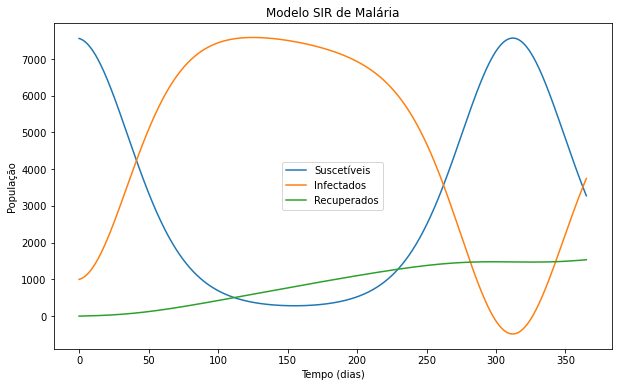

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

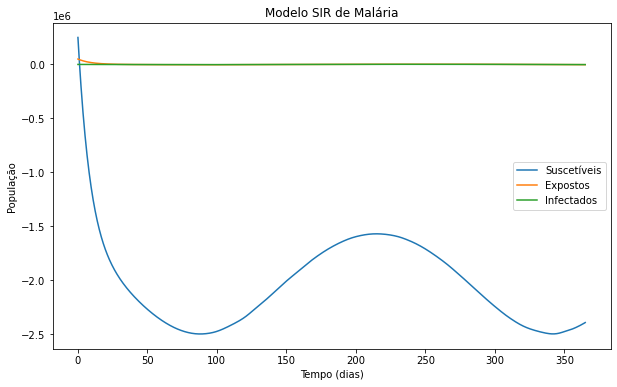

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

#### Aumentando $B_E$:

In [7]:
B_E=400
p_ME=0.9
p_ML=0.25
p_MP=0.75
tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737

A=-0.03
B=1.31
C=-4.4

R_L = 50
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = -404427.43060487596
 
mu = 0.1115841612302408
muM = 33475.24836907224
b = -404427.4688147092
 
mu = 0.11158416212099279
muM = 33475.24863629784
b = -404427.6315892765
 
mu = 0.11158416591561074
muM = 33475.24977468322
b = -404427.73208156833
 
mu = 0.11158416825829603
muM = 33475.25047748881
b = -404427.8828201217
 
mu = 0.11158417177232448
muM = 33475.251531697344
b = -404428.5067869013
 
mu = 0.11158418631825677
muM = 33475.25589547703
b = -404428.70427074604
 
mu = 0.11158419092199662
muM = 33475.25727659898
b = -404428.3858533551
 
mu = 0.11158418349905389
muM = 33475.255049716165
b = -404428.6062960988
 
mu = 0.111584188638014
muM = 33475.2565914042
b = -404429.9191612188
 
mu = 0.11158421924340199
muM = 33475.2657730206
b = -404429.72321053623
 
mu = 0.11158421467543093
muM = 33475.264402629284
b = -404430.7057655916
 
mu = 0.11158423758055296
muM = 33475.27127416588
b = -404431.2516320441
 
mu = 0.11158425030563118
muM = 33475.27509168936
b = -404431.2516320441
 
mu = 0.1115

muM = 34226.74591161879
b = -547040.0360276194
 
mu = 0.11400734588127191
muM = 34202.20376438157
b = -513388.450697331
 
mu = 0.11341585264541273
muM = 34024.75579362382
b = -518927.5656315076
 
mu = 0.11351416352771439
muM = 34054.249058314315
b = -490007.9699439852
 
mu = 0.1129936455661208
muM = 33898.09366983624
b = -473169.37822488305
 
mu = 0.1126803795787741
muM = 33804.11387363223
b = -473169.37822488305
 
mu = 0.1126803795787741
muM = 33804.11387363223
b = -562188.2965301027
 
mu = 0.1142744029727638
muM = 34282.32089182914
b = -555481.9724880247
 
mu = 0.11415541709590069
muM = 34246.6251287702
b = -499196.9415223379
 
mu = 0.1131611425824943
muM = 33948.342774748286
b = -465550.36984647904
 
mu = 0.11253554548853958
muM = 33760.66364656187
b = -461747.33247291594
 
mu = 0.11246244742710933
muM = 33738.734228132795
b = -456062.3222858956
 
mu = 0.1123521086008108
muM = 33705.63258024324
b = -433044.70011826896
 
mu = 0.11189041327464816
muM = 33567.12398239445
b = -426024.24

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 281
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff144fc550>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

#### Diminuindo $B_E$:

In [8]:
B_E=100
p_ME=0.9
p_ML=0.25
p_MP=0.75
tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737

A=-0.03
B=1.31
C=-4.4

R_L = 50
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = -101106.85765121899
 
mu = 0.1115841612302408
muM = 33475.24836907224
b = -101106.86720368513
 
mu = 0.11158416212099352
muM = 33475.248636298056
b = -101106.90789736062
 
mu = 0.1115841659156146
muM = 33475.24977468438
b = -101106.9330204544
 
mu = 0.11158416825830188
muM = 33475.25047749056
b = -101106.97070512369
 
mu = 0.11158417177233317
muM = 33475.25153169995
b = -101107.12669694742
 
mu = 0.1115841863182775
muM = 33475.25589548325
b = -101107.17606794933
 
mu = 0.1115841909220212
muM = 33475.25727660636
b = -101107.09646353584
 
mu = 0.11158418349907226
muM = 33475.25504972168
b = -101107.15157426726
 
mu = 0.1115841886380366
muM = 33475.25659141098
b = -101107.47979081824
 
mu = 0.11158421924344991
muM = 33475.265773034975
b = -101107.43080310721
 
mu = 0.11158421467547512
muM = 33475.26440264253
b = -101107.67644207376
 
mu = 0.11158423758061589
muM = 33475.271274184764
b = -101107.81290879962
 
mu = 0.11158425030570479
muM = 33475.27509171144
b = -101107.81290879962
 
mu

mu = 0.11005420584129312
muM = 33016.26175238794
b = -91137.09722367984
 
mu = 0.1102643563498861
muM = 33079.30690496583
b = -89920.34891928198
 
mu = 0.11011741213790431
muM = 33035.223641371296
b = -85446.901267556
 
mu = 0.10939199006142622
muM = 32817.59701842786
b = -85805.2978675913
 
mu = 0.1094824787747751
muM = 32844.74363243253
b = -85118.9463388339
 
mu = 0.10909783373316126
muM = 32729.350119948376
b = -85933.80918761974
 
mu = 0.10896163342448656
muM = 32688.490027345968
b = -85933.80918761974
 
mu = 0.10896163342448656
muM = 32688.490027345968
b = -96745.46647600732
 
mu = 0.11086137145124798
muM = 33258.41143537439
b = -96221.5896102762
 
mu = 0.11080948853889679
muM = 33242.84656166904
b = -95455.45187466098
 
mu = 0.11073245202910428
muM = 33219.73560873129
b = -92546.36280432204
 
mu = 0.1104247432474604
muM = 33127.42297423812
b = -91717.30724045652
 
mu = 0.11033149884181925
muM = 33099.44965254577
b = -93076.22531183629
 
mu = 0.11048287398697308
muM = 33144.86219

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 281
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff148eec90>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

$\mu M \approx 33475$. Testando parâmetros para $b$:

In [9]:
def lotkavolterra(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    print(f'b = {b_curr}')
    print(' ')
    print(f'p_ER = {p_ER(R_curr)}')
    print(f'p_LRT = {p_LRT(R_curr,T_curr)}')
    print(f'p_PR = {p_PR(R_curr)}')
    

    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [10]:
B_E=100
p_ME=0.9
p_ML=0.25
p_MP=0.75
tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737

A=-0.03
B=1.31
C=-4.4

R_L = 50
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = -101106.85765121899
 
p_ER = -40.35215463840414
p_LRT = -10.29985864660012
p_PR = -33.62679553200344
b = -101106.86720368513
 
p_ER = -40.35215576449653
p_LRT = -10.29985892187331
p_PR = -33.62679647041377
b = -101106.90789736062
 
p_ER = -40.352160561669564
p_LRT = -10.299860094541867
p_PR = -33.62680046805797
b = -101106.9330204544
 
p_ER = -40.35216352330447
p_LRT = -10.299860818513292
p_PR = -33.62680293608705
b = -101106.97070512369
 
p_ER = -40.352167965759534
p_LRT = -10.29986190447112
p_PR = -33.62680663813294
b = -101107.12669694742
 
p_ER = -40.352186354838295
p_LRT = -10.29986639968041
p_PR = -33.62682196236524
b = -101107.17606794933
 
p_ER = -40.352192174930536
p_LRT = -10.299867822401737
p_PR = -33.626826812442104
b = -101107.09646353584
 
p_ER = -40.35218279077699
p_LRT = -10.299865528445782
p_PR = -33.626818992314156
b = -101107.15157426726
 
p_ER = -40.35218928749712
p_LRT = -10.299867116568741
p_PR = -33.62682440624759
b = -101107.47979081824
 
p_ER = -40.35222797

p_LRT = -10.120110224250515
p_PR = -32.91024652014827
b = -91343.1039705283
 
p_ER = -39.49229582417792
p_LRT = -10.120110224250515
p_PR = -32.91024652014827
b = -85085.98319038654
 
p_ER = -38.49559217059417
p_LRT = -9.85883847725404
p_PR = -32.079660142161806
b = -85035.50131921946
 
p_ER = -38.50573326876555
p_LRT = -9.86285722243372
p_PR = -32.08811105730462
b = -88428.57023495073
 
p_ER = -39.068484498357286
p_LRT = -10.011567570509854
p_PR = -32.55707041529774
b = -92747.57090697518
 
p_ER = -39.68966060340152
p_LRT = -10.170367053010358
p_PR = -33.074717169501255
b = -93497.79761331709
 
p_ER = -39.79358692164669
p_LRT = -10.196775188529209
p_PR = -33.161322434705575
b = -94681.17629424564
 
p_ER = -39.95556862402073
p_LRT = -10.237868088049465
p_PR = -33.29630718668394
b = -100261.9255090511
 
p_ER = -40.69134482634338
p_LRT = -10.423663387374974
p_PR = -33.90945402195282
b = -102231.18761221485
 
p_ER = -40.94110980611531
p_LRT = -10.486452213945821
p_PR = -34.11759150509609
b

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 281
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff14629590>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

#### Aumentando $R_L$:

In [11]:
B_E=100
p_ME=0.9
p_ML=0.25
p_MP=0.75
tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737

A=-0.03
B=1.31
C=-4.4

R_L = 250
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 0.3734036693399422
 
p_ER = 0.6237339527010325
p_LRT = 0.15920764587355066
p_PR = 0.5197782939175271
b = 0.373403640256116
 
p_ER = 0.6237339342702194
p_LRT = 0.15920764098112156
p_PR = 0.5197782785585161
b = 0.37340351635851177
 
p_ER = 0.623733855754633
p_LRT = 0.15920762013928869
p_PR = 0.519778213128861
b = 0.3734034398677373
 
p_ER = 0.6237338072813937
p_LRT = 0.15920760727214775
p_PR = 0.5197781727344947
b = 0.3734033251315026
 
p_ER = 0.6237337345714855
p_LRT = 0.15920758797142395
p_PR = 0.5197781121429045
b = 0.37340285019280367
 
p_ER = 0.623733433596355
p_LRT = 0.15920750807808653
p_PR = 0.5197778613302958
b = 0.37340269987601377
 
p_ER = 0.6237333383385436
p_LRT = 0.15920748279206515
p_PR = 0.5197777819487862
b = 0.37340294224258747
 
p_ER = 0.6237334919295627
p_LRT = 0.15920752356253642
p_PR = 0.5197779099413022
b = 0.373402774450386
 
p_ER = 0.6237333855973468
p_LRT = 0.15920749533683262
p_PR = 0.5197778213311223
b = 0.37340177515069334
 
p_ER = 0.6237327523273003
p_LR

b = 0.38848890740583836
 
p_ER = 0.6343313045253658
p_LRT = 0.16210533737844454
p_PR = 0.5286094204378048
b = 0.38848890740583836
 
p_ER = 0.6343313045253658
p_LRT = 0.16210533737844454
p_PR = 0.5286094204378048
b = 0.35305448771596504
 
p_ER = 0.611710027402084
p_LRT = 0.15609805273782992
p_PR = 0.5097583561684034
b = 0.35734460142894703
 
p_ER = 0.614479116419165
p_LRT = 0.15683006991544887
p_PR = 0.5120659303493041
b = 0.38059336888823114
 
p_ER = 0.6293214652933011
p_LRT = 0.1607685012263255
p_PR = 0.5244345544110842
b = 0.3903542994268494
 
p_ER = 0.6355160731750433
p_LRT = 0.162422241531793
p_PR = 0.5295967276458694
b = 0.3912678627892194
 
p_ER = 0.6360967171321349
p_LRT = 0.16257767453524277
p_PR = 0.5300805976101124
b = 0.3926136426186997
 
p_ER = 0.63695270953713
p_LRT = 0.16280697024022675
p_PR = 0.530793924614275
b = 0.3978554208102354
 
p_ER = 0.6402978561981825
p_LRT = 0.1637050373825647
p_PR = 0.5335815468318188
b = 0.3993985727711861
 
p_ER = 0.6412876078862517
p_LRT = 

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 299
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff14821e90>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

Verificar o quão alto pode ser o $R_L$. Descobrir qual é precipitação média na ausência de sazonalidade($R_1$).

Modificando o nível de precipitação médio ($R_1$):

In [12]:
# Funções de temperatura e chuva fora do contexto da função lotkavolterra
def T(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

def R(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

In [13]:
R1=146.9
R2=0.033
omega2=0.025
phi2=1.99

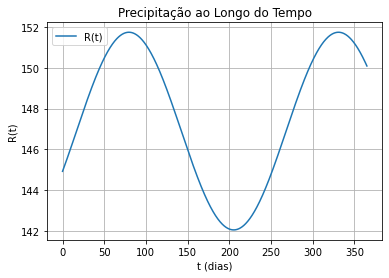

In [14]:
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
R_values = [R(t) for t in t_values]

# Plotando
plt.plot(t_values, R_values, label='R(t)')
plt.title('Precipitação ao Longo do Tempo')
plt.xlabel('t (dias)')
plt.ylabel('R(t)')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
B_E=100
p_ME=0.9
p_ML=0.25
p_MP=0.75
tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737

A=-0.03
B=1.31
C=-4.4

R_L = 150
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 0.002505106577817825
 
p_ER = 0.11763826049066091
p_LRT = 0.03002708195741714
p_PR = 0.09803188374221743
b = 0.002505104140955381
 
p_ER = 0.11763822192423772
p_LRT = 0.030027072077912068
p_PR = 0.09803185160353142
b = 0.0025050937598962756
 
p_ER = 0.1176380576306018
p_LRT = 0.03002702999104837
p_PR = 0.09803171469216816
b = 0.002505087350946627
 
p_ER = 0.11763795620049274
p_LRT = 0.03002700400784394
p_PR = 0.09803163016707728
b = 0.0025050777375360983
 
p_ER = 0.11763780405523033
p_LRT = 0.030026965033012377
p_PR = 0.0980315033793586
b = 0.0025050379440806183
 
p_ER = 0.11763717426573848
p_LRT = 0.030026803700755295
p_PR = 0.09803097855478209
b = 0.002505025349647718
 
p_ER = 0.11763697493909386
p_LRT = 0.030026752639540688
p_PR = 0.09803081244924489
b = 0.002505045656578358
 
p_ER = 0.11763729632778104
p_LRT = 0.03002683496921036
p_PR = 0.09803108027315086
b = 0.002505031597926116
 
p_ER = 0.11763707382797703
p_LRT = 0.03002677797176095
p_PR = 0.09803089485664752
b = 0.00250494

p_LRT = 0.038344559226225323
p_PR = 0.12499223162043603
b = 0.004779256729722873
 
p_ER = 0.14654195472422032
p_LRT = 0.03745812067563298
p_PR = 0.12211829560351693
b = 0.0050142345297618475
 
p_ER = 0.14894626225525812
p_LRT = 0.038076068669515684
p_PR = 0.12412188521271508
b = 0.006377623676361951
 
p_ER = 0.16163547213437665
p_LRT = 0.04134090701380323
p_PR = 0.1346962267786472
b = 0.006181765458289116
 
p_ER = 0.15992679308029065
p_LRT = 0.04090087604462592
p_PR = 0.13327232756690885
b = 0.007116450002077492
 
p_ER = 0.1678009073531075
p_LRT = 0.04293008046872272
p_PR = 0.13983408946092293
b = 0.007571218207169988
 
p_ER = 0.1714034339230935
p_LRT = 0.04386001087403035
p_PR = 0.14283619493591124
b = 0.007571218207169988
 
p_ER = 0.1714034339230935
p_LRT = 0.04386001087403035
p_PR = 0.14283619493591124
b = 0.004172044552539296
 
p_ER = 0.13995122360553877
p_LRT = 0.03576507114016243
p_PR = 0.1166260196712823
b = 0.004575895222711592
 
p_ER = 0.14439856916193644
p_LRT = 0.03690738370

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 329
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff14804290>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

In [16]:
B_E=100
p_ME=0.9
p_ML=0.45
p_MP=0.85
tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737

A=-0.03
B=1.31
C=-4.4

R_L = 150
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 0.005110417418748362
 
p_ER = 0.11763826049066091
p_LRT = 0.05404874752335085
p_PR = 0.11110280157451308
b = 0.005110412447548978
 
p_ER = 0.11763822192423772
p_LRT = 0.05404872974024172
p_PR = 0.11110276515066896
b = 0.005110391270188403
 
p_ER = 0.1176380576306018
p_LRT = 0.054048653983887064
p_PR = 0.11110260998445724
b = 0.005110378195931119
 
p_ER = 0.11763795620049274
p_LRT = 0.05404860721411909
p_PR = 0.11110251418935425
b = 0.005110358584573641
 
p_ER = 0.11763780405523033
p_LRT = 0.05404853705942228
p_PR = 0.11110237049660641
b = 0.005110277405924461
 
p_ER = 0.11763717426573848
p_LRT = 0.054048246661359524
p_PR = 0.11110177569541967
b = 0.005110251713281345
 
p_ER = 0.11763697493909386
p_LRT = 0.05404815475117324
p_PR = 0.11110158744247754
b = 0.005110293139419851
 
p_ER = 0.11763729632778104
p_LRT = 0.05404830294457865
p_PR = 0.11110189097623764
b = 0.0051102644597692745
 
p_ER = 0.11763707382797703
p_LRT = 0.054048200349169705
p_PR = 0.11110168083753386
b = 0.0051100936

 
p_ER = 0.12874387514082022
p_LRT = 0.05919963840488823
p_PR = 0.12159143763299687
b = 0.0077018904896482745
 
p_ER = 0.13530182728144652
p_LRT = 0.062228564518396055
p_PR = 0.12778505909914392
b = 0.0077018904896482745
 
p_ER = 0.13530182728144652
p_LRT = 0.062228564518396055
p_PR = 0.12778505909914392
b = 0.002256874201428637
 
p_ER = 0.08949103992085805
p_LRT = 0.04110239910661087
p_PR = 0.08451931548081038
b = 0.00269624755577776
 
p_ER = 0.09500176176824396
p_LRT = 0.043640107853269584
p_PR = 0.08972388611445262
b = 0.006086385130988912
 
p_ER = 0.12496106785253328
p_LRT = 0.057453268491761335
p_PR = 0.1180187863051703
b = 0.008133690124271904
 
p_ER = 0.13782075605336064
p_LRT = 0.06339247992311428
p_PR = 0.13016404738372947
b = 0.008351584998964056
 
p_ER = 0.1390588469627837
p_LRT = 0.0639646681771831
p_PR = 0.13133335546485125
b = 0.008680517681622358
 
p_ER = 0.14088862916695122
p_LRT = 0.06481044158905495
p_PR = 0.1330614831021206
b = 0.01005832268961407
 
p_ER = 0.14809852

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 329
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff1af4ae50>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

Diminuindo a duração da fase de desenvolvimento das larvas (aumentando $c_1$ e $c_2$)

In [17]:
B_E=100
p_ME=0.9
p_ML=0.45
p_MP=0.85
tau_E=1
tau_P=1
c1=0.008
c2=-0.03

A=-0.03
B=1.31
C=-4.4

R_L = 150
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 0.00873865114813379
 
p_ER = 0.11763826049066091
p_LRT = 0.04866906654721152
p_PR = 0.11110280157451308
b = 0.00873864259566708
 
p_ER = 0.11763822192423772
p_LRT = 0.04866905050860765
p_PR = 0.11110276515066896
b = 0.008738606162071711
 
p_ER = 0.1176380576306018
p_LRT = 0.04866898218387603
p_PR = 0.11110260998445724
b = 0.008738583669080553
 
p_ER = 0.11763795620049274
p_LRT = 0.048668940002175975
p_PR = 0.11110251418935425
b = 0.008738549929643787
 
p_ER = 0.11763780405523033
p_LRT = 0.04866887672958572
p_PR = 0.11110237049660641
b = 0.00873841026967156
 
p_ER = 0.11763717426573848
p_LRT = 0.04866861481929014
p_PR = 0.11110177569541967
b = 0.00873836606798184
 
p_ER = 0.11763697493909386
p_LRT = 0.04866853192540485
p_PR = 0.11110158744247754
b = 0.008738437337618811
 
p_ER = 0.11763729632778104
p_LRT = 0.048668665581179806
p_PR = 0.11110189097623764
b = 0.008738387997072402
 
p_ER = 0.11763707382797703
p_LRT = 0.048668573050281584
p_PR = 0.11110168083753386
b = 0.008738094149360

b = 0.008969370223173427
 
p_ER = 0.11874632472164871
p_LRT = 0.04916326616347232
p_PR = 0.1121493066815571
b = 0.00839940545036571
 
p_ER = 0.11616326769867373
p_LRT = 0.04808835781157388
p_PR = 0.10970975282652519
b = 0.011417343976675666
 
p_ER = 0.1287484917464187
p_LRT = 0.05332856921961294
p_PR = 0.12159579776050655
b = 0.013240711760334131
 
p_ER = 0.13530691156191266
p_LRT = 0.05606256998993746
p_PR = 0.12778986091958416
b = 0.013240711760334131
 
p_ER = 0.13530691156191266
p_LRT = 0.05606256998993746
p_PR = 0.12778986091958416
b = 0.003852642774780631
 
p_ER = 0.08949189996764295
p_LRT = 0.03700602112625535
p_PR = 0.08452012774721834
b = 0.004606292414816814
 
p_ER = 0.09500320848933061
p_LRT = 0.03929370969672685
p_PR = 0.08972525246214556
b = 0.010445381399566592
 
p_ER = 0.12496538469966477
p_LRT = 0.05175254884514111
p_PR = 0.11802286332746116
b = 0.013992361440967705
 
p_ER = 0.13783658961767722
p_LRT = 0.05711776317250094
p_PR = 0.13017900130558405
b = 0.0143718789304461

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 329
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff148f5810>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

In [18]:
B_E=100
p_ME=0.9
p_ML=0.45
p_MP=0.85
tau_E=1
tau_P=1
c1=0.02
c2=-0.015

A=-0.03
B=1.31
C=-4.4

R_L = 150
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 0.011638249525053622
 
p_ER = 0.11763826049066091
p_LRT = 0.03449824287724484
p_PR = 0.11110280157451308
b = 0.011638238074007571
 
p_ER = 0.11763822192423772
p_LRT = 0.0344982314203237
p_PR = 0.11110276515066896
b = 0.011638189292435718
 
p_ER = 0.1176380576306018
p_LRT = 0.03449818261364114
p_PR = 0.11110260998445724
b = 0.01163815917618113
 
p_ER = 0.11763795620049274
p_LRT = 0.03449815248181701
p_PR = 0.11110251418935425
b = 0.011638114001867364
 
p_ER = 0.11763780405523033
p_LRT = 0.03449810728405311
p_PR = 0.11110237049660641
b = 0.011637927008737314
 
p_ER = 0.11763717426573848
p_LRT = 0.034497920192630836
p_PR = 0.11110177569541967
b = 0.011637867826342664
 
p_ER = 0.11763697493909386
p_LRT = 0.03449786097871659
p_PR = 0.11110158744247754
b = 0.011637963250473789
 
p_ER = 0.11763729632778104
p_LRT = 0.034497956453571614
p_PR = 0.11110189097623764
b = 0.011637897187574929
 
p_ER = 0.11763707382797703
p_LRT = 0.03449789035561086
p_PR = 0.11110168083753386
b = 0.01163750374992

b = 0.03638550323383575
 
p_ER = 0.17197074239168242
p_LRT = 0.05089424139864291
p_PR = 0.16241681225881113
b = 0.03638550323383575
 
p_ER = 0.17197074239168242
p_LRT = 0.05089424139864291
p_PR = 0.16241681225881113
b = 0.019655710838106414
 
p_ER = 0.14007504203758192
p_LRT = 0.04125583565331202
p_PR = 0.13229309525771624
b = 0.021634077027248472
 
p_ER = 0.1446229297655817
p_LRT = 0.042619963330921835
p_PR = 0.13658832255638267
b = 0.03279431188639874
 
p_ER = 0.1661201990188815
p_LRT = 0.04910924695872624
p_PR = 0.15689129907338809
b = 0.03725564765421883
 
p_ER = 0.17332968641395408
p_LRT = 0.05131111485086157
p_PR = 0.16370025939095662
b = 0.03766844101813202
 
p_ER = 0.17396694386882985
p_LRT = 0.05150701589043516
p_PR = 0.16430211365389485
b = 0.03825840781817148
 
p_ER = 0.17486964866188406
p_LRT = 0.0517850591368923
p_PR = 0.1651546681806683
b = 0.04029681183690551
 
p_ER = 0.177918513355705
p_LRT = 0.05273116055635083
p_PR = 0.16803415150261025
b = 0.04079638240309204
 
p_ER 

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 329
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff148e5510>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

Aumentando o número de ovos colocados por adulto ($B_E$):

In [19]:
B_E=400
p_ME=0.9
p_ML=0.45
p_MP=0.85
tau_E=1
tau_P=1
c1=0.02
c2=-0.015

A=-0.03
B=1.31
C=-4.4

R_L = 150
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 0.04655299810021449
 
p_ER = 0.11763826049066091
p_LRT = 0.03449824287724484
p_PR = 0.11110280157451308
b = 0.046552952296030285
 
p_ER = 0.11763822192423772
p_LRT = 0.0344982314203237
p_PR = 0.11110276515066896
b = 0.04655275716974287
 
p_ER = 0.1176380576306018
p_LRT = 0.03449818261364114
p_PR = 0.11110260998445724
b = 0.04655263670472452
 
p_ER = 0.11763795620049274
p_LRT = 0.03449815248181701
p_PR = 0.11110251418935425
b = 0.046552456007469455
 
p_ER = 0.11763780405523033
p_LRT = 0.03449810728405311
p_PR = 0.11110237049660641
b = 0.046551708034949256
 
p_ER = 0.11763717426573848
p_LRT = 0.034497920192630836
p_PR = 0.11110177569541967
b = 0.046551471305370656
 
p_ER = 0.11763697493909386
p_LRT = 0.03449786097871659
p_PR = 0.11110158744247754
b = 0.046551853001895155
 
p_ER = 0.11763729632778104
p_LRT = 0.034497956453571614
p_PR = 0.11110189097623764
b = 0.046551588750299716
 
p_ER = 0.11763707382797703
p_LRT = 0.03449789035561086
p_PR = 0.11110168083753386
b = 0.0465500149997084

b = 0.07094119297922588
 
p_ER = 0.13535811653790608
p_LRT = 0.0398434442489896
p_PR = 0.12783822117468907
b = 0.020498873762457927
 
p_ER = 0.08950069960392858
p_LRT = 0.02621415088364495
p_PR = 0.08452843851482143
b = 0.024529576622388985
 
p_ER = 0.09501790127601932
p_LRT = 0.027845518109167324
p_PR = 0.08973912898290713
b = 0.055875745028786554
 
p_ER = 0.12500889377383403
p_LRT = 0.03675237655087312
p_PR = 0.11806395523084327
b = 0.07499594527864126
 
p_ER = 0.1378881716292537
p_LRT = 0.04060072386925038
p_PR = 0.1302277176498507
b = 0.0770441287590279
 
p_ER = 0.13913159449394327
p_LRT = 0.04097314677811776
p_PR = 0.13140206146650196
b = 0.08013864923604798
 
p_ER = 0.14096907660113864
p_LRT = 0.04152381030552487
p_PR = 0.13313746123440873
b = 0.09313392608391413
 
p_ER = 0.1482068293881976
p_LRT = 0.04369671968106349
p_PR = 0.13997311664440884
b = 0.09727106181803295
 
p_ER = 0.15036847562483568
p_LRT = 0.044346990103373674
p_PR = 0.14201467142345592
b = 0.090601395405564
 
p_ER

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 353
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff1b085c90>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

Aumentando $R_L$:

In [20]:
B_E=400
p_ME=0.9
p_ML=0.45
p_MP=0.85
tau_E=1
tau_P=1
c1=0.02
c2=-0.015

A=-0.03
B=1.31
C=-4.4

R_L = 200
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 10.599761110131809
 
p_ER = 0.7183422345843472
p_LRT = 0.21065888575971387
p_PR = 0.6784343326629946
b = 10.599760488923081
 
p_ER = 0.7183422206465606
p_LRT = 0.21065888077443296
p_PR = 0.6784343194995294
b = 10.599757842563239
 
p_ER = 0.7183421612713444
p_LRT = 0.21065885953705132
p_PR = 0.6784342634229362
b = 10.599756208777839
 
p_ER = 0.7183421246148122
p_LRT = 0.21065884642571156
p_PR = 0.6784342288028781
b = 10.599753758098363
 
p_ER = 0.7183420696299757
p_LRT = 0.21065882675869138
p_PR = 0.6784341768727548
b = 10.599743613768227
 
p_ER = 0.7183418420259314
p_LRT = 0.21065874534913492
p_PR = 0.6784339619133797
b = 10.599740403116508
 
p_ER = 0.718341769989866
p_LRT = 0.21065871958324342
p_PR = 0.6784338938793177
b = 10.599745579881441
 
p_ER = 0.7183418861387936
p_LRT = 0.21065876112744597
p_PR = 0.6784340035755272
b = 10.599741995968042
 
p_ER = 0.7183418057280193
p_LRT = 0.210658732366081
p_PR = 0.6784339276320182
b = 10.599720651699133
 
p_ER = 0.7183413268351501
p_LRT =

p_ER = 0.7347382294269447
p_LRT = 0.2171078156932136
p_PR = 0.6939194389032254
b = 11.532516936320654
 
p_ER = 0.7386317585032095
p_LRT = 0.21870959307367932
p_PR = 0.6975966608085866
b = 11.51066800058233
 
p_ER = 0.7381698753439676
p_LRT = 0.21850950365311192
p_PR = 0.6971604378248581
b = 11.599936212160037
 
p_ER = 0.7400504528912649
p_LRT = 0.21936856295519308
p_PR = 0.6989365388417502
b = 11.62717472454814
 
p_ER = 0.7406184718167819
p_LRT = 0.21968664968433987
p_PR = 0.699473001160294
b = 11.62717472454814
 
p_ER = 0.7406184718167819
p_LRT = 0.21968664968433987
p_PR = 0.699473001160294
b = 11.199456073011058
 
p_ER = 0.7315123772918
p_LRT = 0.215858127536961
p_PR = 0.6908728007755888
b = 11.275134428102561
 
p_ER = 0.7331438728752545
p_LRT = 0.2164847675067078
p_PR = 0.692413657715518
b = 11.577838420671137
 
p_ER = 0.7395867767412858
p_LRT = 0.21914220824560923
p_PR = 0.698498622477881
b = 11.635048698250325
 
p_ER = 0.7407803960347795
p_LRT = 0.21980882610108918
p_PR = 0.699625

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 299
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff1711bdd0>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

In [21]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

In [22]:
S_M

array([2.50000000e+05, 2.40014743e+05, 2.30426557e+05, 2.21219728e+05,
       2.12379158e+05, 2.03890347e+05, 1.95739377e+05, 1.87912850e+05,
       1.80397904e+05, 1.73182197e+05, 1.66253878e+05, 1.59601567e+05,
       1.53214331e+05, 1.47081665e+05, 1.41193475e+05, 1.35540060e+05,
       1.30112096e+05, 1.24900625e+05, 1.19897040e+05, 1.15093071e+05,
       1.10480776e+05, 1.06052532e+05, 1.01801018e+05, 9.77192106e+04,
       9.38003712e+04, 9.00380348e+04, 8.64259999e+04, 8.29583167e+04,
       7.96292755e+04, 7.64333933e+04, 7.33654000e+04, 7.04202235e+04,
       6.75929732e+04, 6.48789219e+04, 6.22734865e+04, 5.97722074e+04,
       5.73709678e+04, 5.50658856e+04, 5.28531168e+04, 5.07289792e+04,
       4.86899424e+04, 4.67326195e+04, 4.48537594e+04, 4.30502400e+04,
       4.13190613e+04, 3.96573403e+04, 3.80623055e+04, 3.65312926e+04,
       3.50617400e+04, 3.36511855e+04, 3.22972626e+04, 3.09976973e+04,
       2.97503058e+04, 2.85529913e+04, 2.74037417e+04, 2.63006274e+04,
      

Testando a precipitação:

In [23]:
R1=146.9
R2=0.033
omega2=0.025
phi2=1.99

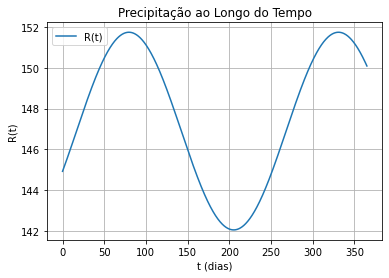

In [24]:
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
R_values = [R(t) for t in t_values]

# Plotando
plt.plot(t_values, R_values, label='R(t)')
plt.title('Precipitação ao Longo do Tempo')
plt.xlabel('t (dias)')
plt.ylabel('R(t)')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
R1=146.9
R2=0.033
omega2=0.02
phi2=1.99

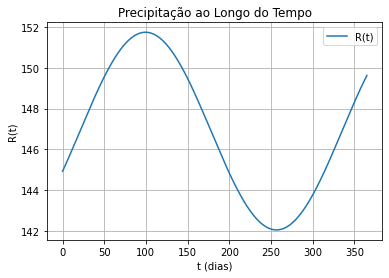

In [26]:
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
R_values = [R(t) for t in t_values]

# Plotando
plt.plot(t_values, R_values, label='R(t)')
plt.title('Precipitação ao Longo do Tempo')
plt.xlabel('t (dias)')
plt.ylabel('R(t)')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
def lotkavolterra(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    b_curr = b(R_curr, T_curr)
    print(f'b = {b_curr}')
    print(' ')
    print(f'p_ER = {p_ER(R_curr)}')
    print(f'p_LRT = {p_LRT(R_curr,T_curr)}')
    print(f'p_PR = {p_PR(R_curr)}')
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt]

In [28]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 10.599761110131809
 
p_ER = 0.7183422345843472
p_LRT = 0.21065888575971387
p_PR = 0.6784343326629946
b = 10.59976061232154
 
p_ER = 0.718342223434118
p_LRT = 0.21065888159190366
p_PR = 0.6784343221322227
b = 10.59975849164147
 
p_ER = 0.7183421759339513
p_LRT = 0.21065886383696328
p_PR = 0.678434277270954
b = 10.599757182395598
 
p_ER = 0.718342146608734
p_LRT = 0.21065885287558278
p_PR = 0.6784342495749153
b = 10.599755218525887
 
p_ER = 0.718342102620883
p_LRT = 0.21065883643350528
p_PR = 0.6784342080308339
b = 10.599747089296482
 
p_ER = 0.718341920537802
p_LRT = 0.21065876837328748
p_PR = 0.6784340360634796
b = 10.59974451641938
 
p_ER = 0.7183418629090247
p_LRT = 0.2106587468324329
p_PR = 0.678433981636301
b = 10.599748664854607
 
p_ER = 0.718341955828052
p_LRT = 0.21065878156430637
p_PR = 0.6784340693931602
b = 10.599745792861492
 
p_ER = 0.7183418914995086
p_LRT = 0.21065875751916696
p_PR = 0.6784340086384247
b = 10.599728688499814
 
p_ER = 0.7183415083859914
p_LRT = 0.21065

 
p_ER = 0.6843347792460093
p_LRT = 0.2008613053969498
p_PR = 0.6463161803990087
b = 9.204598043958075
 
p_ER = 0.6853064812794218
p_LRT = 0.20121535469588325
p_PR = 0.6472338989861205
b = 9.141332083617918
 
p_ER = 0.683744196992512
p_LRT = 0.20064589031624708
p_PR = 0.6457584082707056
b = 9.18500180546045
 
p_ER = 0.6848233078598579
p_LRT = 0.20103936366719938
p_PR = 0.6467775685343101
b = 9.45585644017136
 
p_ER = 0.6914441079654869
p_LRT = 0.20344179197030818
p_PR = 0.6530305464118487
b = 9.41441927477259
 
p_ER = 0.6904391622400275
p_LRT = 0.20307833623393942
p_PR = 0.6520814310044704
b = 9.624847327413802
 
p_ER = 0.6955134573343165
p_LRT = 0.2049094928017838
p_PR = 0.6568738208157433
b = 9.743963213093595
 
p_ER = 0.6983542361897398
p_LRT = 0.2059303302357692
p_PR = 0.659556778623643
b = 9.743963213093595
 
p_ER = 0.6983542361897398
p_LRT = 0.2059303302357692
p_PR = 0.659556778623643
b = 9.030734644180502
 
p_ER = 0.680996490642395
p_LRT = 0.1996411988557603
p_PR = 0.64316335227

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 284
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff14700e50>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

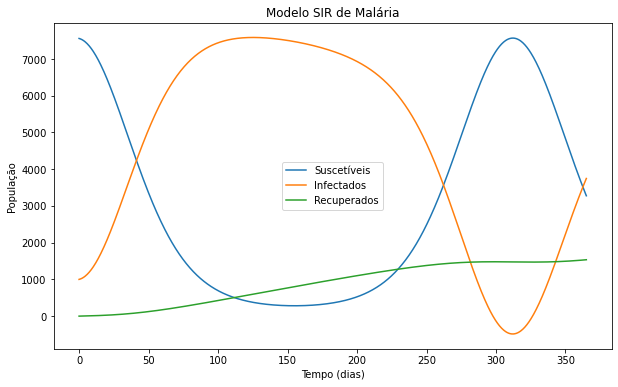

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

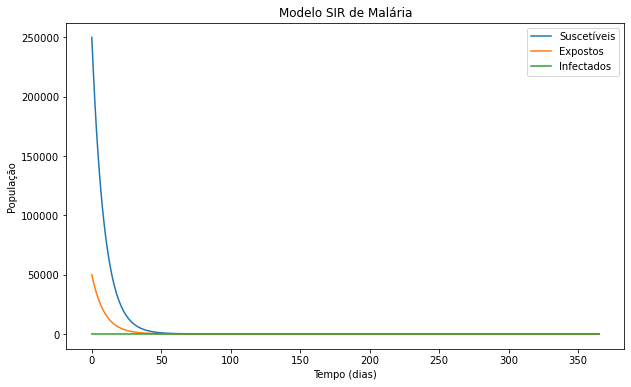

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Alterando $c1$ e $c2$:

In [31]:
def lotkavolterra(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    b_curr = b(R_curr, T_curr)
    print(f'b = {b_curr}')
    print(' ')
    #print(f'p_ER = {p_ER(R_curr)}')
    print(f'p_LT = {p_LT(T_curr)}')
    print(f'tau_L = {tau_L(T_curr)}')
    print(' ')
    print(f'num b: {B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr)}')
    print(f'den b: {(tau_E + tau_L(T_curr) + tau_P)}')
    print(' ')
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt]

In [32]:
B_E=400
p_ME=0.9
p_ML=0.45
p_MP=0.85
tau_E=1
tau_P=1
c1=0.0190
c2=-0.002

A=-0.03
B=1.31
C=-4.4

R_L = 200
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

In [33]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 10.611135182551363
 
p_LT = 0.5950375198094646
tau_L = 1.9262967394817205
 
num b: 41.66246546945119
den b: 3.9262967394817205
 
b = 10.61113468606758
 
p_LT = 0.5950375173999507
tau_L = 1.9262967244561326
 
num b: 41.66246336066999
den b: 3.9262967244561326
 
b = 10.61113257103835
 
p_LT = 0.5950375071353853
tau_L = 1.9262966604469063
 
num b: 41.66245437722727
den b: 3.9262966604469063
 
b = 10.611131265281136
 
p_LT = 0.595037500798346
tau_L = 1.9262966209295036
 
num b: 41.662448831112734
den b: 3.9262966209295036
 
b = 10.611129306644415
 
p_LT = 0.5950374912927877
tau_L = 1.9262965616534056
 
num b: 41.662440511937646
den b: 3.9262965616534053
 
b = 10.611121199076331
 
p_LT = 0.5950374519456032
tau_L = 1.9262963162867235
 
num b: 41.66240607560536
den b: 3.9262963162867237
 
b = 10.61111863305495
 
p_LT = 0.595037439492356
tau_L = 1.9262962386290312
 
num b: 41.662395176610076
den b: 3.926296238629031
 
b = 10.611122770436198
 
p_LT = 0.595037459571629
tau_L = 1.926296363842

b = 8.201694446815356
 
p_LT = 0.588047631441316
tau_L = 1.8834259940680909
 
num b: 31.850673410166667
den b: 3.883425994068091
 
b = 8.210628209044444
 
p_LT = 0.587968249276783
tau_L = 1.8829472245917571
 
num b: 31.881436016463912
den b: 3.8829472245917573
 
b = 8.204229755957321
 
p_LT = 0.588022274144573
tau_L = 1.8832730397785733
 
num b: 31.85926422345821
den b: 3.8832730397785733
 
b = 8.186112986472613
 
p_LT = 0.5884295913720652
tau_L = 1.8857321722762723
 
num b: 31.80904259742523
den b: 3.8857321722762723
 
b = 8.186635866958326
 
p_LT = 0.5883596620423522
tau_L = 1.885309646344501
 
num b: 31.80761530500306
den b: 3.885309646344501
 
b = 8.191727469405553
 
p_LT = 0.5887414908712166
tau_L = 1.8876184225514157
 
num b: 31.846310622581516
den b: 3.887618422551416
 
b = 8.202865186269312
 
p_LT = 0.5889864266186497
tau_L = 1.8891016465344146
 
num b: 31.90177650221981
den b: 3.8891016465344146
 
b = 8.202865186269312
 
p_LT = 0.5889864266186497
tau_L = 1.8891016465344146
 
n

b = 11.63059473399939
 
p_LT = 0.6027315700481338
tau_L = 1.9751785676091214
 
num b: 46.23369091514188
den b: 3.975178567609121
 
b = 11.642778916220344
 
p_LT = 0.6025156688982352
tau_L = 1.9737818316251061
 
num b: 46.265863326904245
den b: 3.9737818316251063
 
b = 11.51526962009418
 
p_LT = 0.6004974190577634
tau_L = 1.9607960959567183
 
num b: 45.609634955158036
den b: 3.9607960959567183
 
b = 11.341637718627963
 
p_LT = 0.5991583364029218
tau_L = 1.952250371874542
 
num b: 44.8249918911137
den b: 3.952250371874542
 
b = 11.321531316954935
 
p_LT = 0.5990204929241181
tau_L = 1.9513738342301226
 
num b: 44.73560260923263
den b: 3.9513738342301226
 
b = 11.290288822588245
 
p_LT = 0.5988110026518619
tau_L = 1.9500428198172077
 
num b: 44.59712429732717
den b: 3.9500428198172077
 
b = 11.147741492072905
 
p_LT = 0.5979131178988865
tau_L = 1.9443532955010487
 
num b: 43.970630891651545
den b: 3.944353295501049
 
b = 11.098428532426592
 
p_LT = 0.5976201763770964
tau_L = 1.942502382512

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 284
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff14928850>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

In [34]:
B_E=400
p_ME=0.9
p_ML=0.45
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

A=-0.03
B=1.31
C=-4.4

R_L = 200
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

In [35]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 10.616793553625385
 
p_LT = 0.6064513204286237
tau_L = 1.9994768691834888
 
num b: 42.4616202426211
den b: 3.9994768691834888
 
b = 10.616793059221552
 
p_LT = 0.6064513179728913
tau_L = 1.9994768529945692
 
num b: 42.461618093389994
den b: 3.9994768529945692
 
b = 10.616790953052943
 
p_LT = 0.6064513075114346
tau_L = 1.9994767840295333
 
num b: 42.46160893763003
den b: 3.9994767840295333
 
b = 10.616789652766014
 
p_LT = 0.6064513010528405
tau_L = 1.9994767414525605
 
num b: 42.46160328513188
den b: 3.9994767414525603
 
b = 10.616787702334713
 
p_LT = 0.60645129136495
tau_L = 1.9994766775871078
 
num b: 42.46159480638131
den b: 3.999476677587108
 
b = 10.616779628731994
 
p_LT = 0.6064512512630216
tau_L = 1.9994764132233147
 
num b: 42.46155970950339
den b: 3.9994764132233147
 
b = 10.616777073460517
 
p_LT = 0.6064512385709006
tau_L = 1.9994763295531037
 
num b: 42.461548601447404
den b: 3.9994763295531035
 
b = 10.616781193508913
 
p_LT = 0.6064512590353272
tau_L = 1.9994764644

b = 8.195916868356672
 
p_LT = 0.5996453874677226
tau_L = 1.955352194365578
 
num b: 32.41773777009242
den b: 3.9553521943655783
 
b = 8.20073935053383
 
p_LT = 0.6000345509809636
tau_L = 1.9578358879069164
 
num b: 32.45718050891325
den b: 3.957835887906916
 
b = 8.211712569433992
 
p_LT = 0.6002841917993931
tau_L = 1.9594316031934407
 
num b: 32.513714263757755
den b: 3.9594316031934405
 
b = 8.211712569433992
 
p_LT = 0.6002841917993931
tau_L = 1.9594316031934407
 
num b: 32.513714263757755
den b: 3.9594316031934405
 
b = 8.241442334866264
 
p_LT = 0.5991234827270062
tau_L = 1.9520286843143426
 
num b: 32.57041650751404
den b: 3.9520286843143424
 
b = 8.226578154014177
 
p_LT = 0.5992022117916387
tau_L = 1.9525294954935988
 
num b: 32.51579280072432
den b: 3.9525294954935988
 
b = 8.19719955354492
 
p_LT = 0.5999060421951516
tau_L = 1.957015208458591
 
num b: 32.43644330014722
den b: 3.957015208458591
 
b = 8.217373245029238
 
p_LT = 0.600384176031178
tau_L = 1.9600712502543485
 
nu

b = 10.284264897552157
 
p_LT = 0.6048795049387882
tau_L = 1.9891551018077844
 
num b: 41.0255277844129
den b: 3.9891551018077847
 
b = 10.245778105624087
 
p_LT = 0.6047071180169801
tau_L = 1.9880279342803628
 
num b: 40.860449293666996
den b: 3.988027934280363
 
b = 10.18773979330735
 
p_LT = 0.6044506361848166
tau_L = 1.9863526732507673
 
num b: 40.61192375943397
den b: 3.9863526732507673
 
b = 9.94499607617639
 
p_LT = 0.6034216940906187
tau_L = 1.9796531258851628
 
num b: 39.57763472147104
den b: 3.9796531258851626
 
b = 9.86786642895006
 
p_LT = 0.6031091868647819
tau_L = 1.9776250477592072
 
num b: 39.25067267573396
den b: 3.977625047759207
 
b = 9.99222253657542
 
p_LT = 0.6036164475785978
tau_L = 1.9809185904187074
 
num b: 39.778224455453866
den b: 3.9809185904187077
 
b = 9.906125658386747
 
p_LT = 0.6032633414094845
tau_L = 1.9786250762079889
 
num b: 39.41275995252489
den b: 3.978625076207989
 
b = 9.402032090369284
 
p_LT = 0.6013707130624589
tau_L = 1.9663993186003657
 


  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 284
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff144e08d0>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

In [36]:
B_E=400
p_ME=0.9
p_ML=0.45
p_MP=0.85
tau_E=1
tau_P=1
c1=0.19
c2=-0.21

A=-0.03
B=1.31
C=-4.4

R_L = 200
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

In [37]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 0.21416461752947658
 
p_LT = 0.00672913838709551
tau_L = 0.19994768691834888
 
num b: 0.47115095495372483
den b: 2.1999476869183487
 
b = 0.2141645990419078
 
p_LT = 0.006729138114609287
tau_L = 0.19994768529945692
 
num b: 0.4711509139353314
den b: 2.199947685299457
 
b = 0.21416452028458335
 
p_LT = 0.006729136953814026
tau_L = 0.19994767840295333
 
num b: 0.4711507391963513
den b: 2.1999476784029532
 
b = 0.21416447166213556
 
p_LT = 0.006729136237173441
tau_L = 0.19994767414525605
 
num b: 0.4711506313176627
den b: 2.199947674145256
 
b = 0.21416439872846163
 
p_LT = 0.006729135162212744
tau_L = 0.19994766775871073
 
num b: 0.4711504694996257
den b: 2.1999476677587104
 
b = 0.2141640968276862
 
p_LT = 0.006729130712536076
tau_L = 0.19994764132233142
 
num b: 0.4711497996719956
den b: 2.199947641322331
 
b = 0.21416400127711532
 
p_LT = 0.006729129304229433
tau_L = 0.19994763295531037
 
num b: 0.4711495876738279
den b: 2.1999476329553103
 
b = 0.21416415534022037
 
p_LT = 0.0067

 
p_LT = 0.005970272272128277
tau_L = 0.19527578106312649
 
num b: 0.32377038621433957
den b: 2.1952757810631267
 
b = 0.14749713540695467
 
p_LT = 0.0059755691370376625
tau_L = 0.1953096034426101
 
num b: 0.3238018778391626
den b: 2.19530960344261
 
b = 0.14811334662863154
 
p_LT = 0.0060155821674302765
tau_L = 0.195564512822975
 
num b: 0.32519240773327185
den b: 2.1955645128229753
 
b = 0.14796212298996664
 
p_LT = 0.00600869984692718
tau_L = 0.19552074160118763
 
num b: 0.3248539099958177
den b: 2.1955207416011877
 
b = 0.14892971687204076
 
p_LT = 0.006046356506281246
tau_L = 0.19575986410182616
 
num b: 0.3270138948796757
den b: 2.1957598641018263
 
b = 0.14969299369609612
 
p_LT = 0.006070619208408141
tau_L = 0.19591345427211745
 
num b: 0.32871285886752877
den b: 2.1959134542721177
 
b = 0.14969299369609612
 
p_LT = 0.006070619208408141
tau_L = 0.19591345427211745
 
num b: 0.32871285886752877
den b: 2.1959134542721177
 
b = 0.14757627092653766
 
p_LT = 0.005958442636192632
tau_

b = 0.2585291877003219
 
p_LT = 0.007457720494646694
tau_L = 0.20414389757583754
 
num b: 0.5698355314149028
den b: 2.204143897575838
 
b = 0.2384016170600023
 
p_LT = 0.0071027550669312085
tau_L = 0.20213157722953196
 
num b: 0.5249917289904138
den b: 2.2021315772295322
 
b = 0.2261741909735293
 
p_LT = 0.006909831880378995
tau_L = 0.20101270314824254
 
num b: 0.4978122674570145
den b: 2.2010127031482423
 
b = 0.22495467959927173
 
p_LT = 0.0068911276046517735
tau_L = 0.2009032388949663
 
num b: 0.4951034829346166
den b: 2.2009032388949663
 
b = 0.22311441007231372
 
p_LT = 0.006863063071778064
tau_L = 0.2007386610629913
 
num b: 0.4910165080864029
den b: 2.2007386610629913
 
b = 0.2153996666268133
 
p_LT = 0.006747378834133836
tau_L = 0.2000559688428617
 
num b: 0.4738913222490832
den b: 2.200055968842862
 
b = 0.21294117351969225
 
p_LT = 0.0067111424133704
tau_L = 0.19984068352409007
 
num b: 0.4684366567059816
den b: 2.19984068352409
 
b = 0.21690310438423158
 
p_LT = 0.0067696844

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 299
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff144ac410>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

In [38]:
B_E=200
p_ME=0.9
p_ML=0.45
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

A=-0.03
B=1.31
C=-4.4

R_L = 200
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

In [39]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 5.3083967768126925
 
p_LT = 0.6064513204286237
tau_L = 1.9994768691834888
 
num b: 21.23081012131055
den b: 3.9994768691834888
 
b = 5.308396529610776
 
p_LT = 0.6064513179728913
tau_L = 1.9994768529945692
 
num b: 21.230809046694997
den b: 3.9994768529945692
 
b = 5.308395476526472
 
p_LT = 0.6064513075114346
tau_L = 1.9994767840295333
 
num b: 21.230804468815016
den b: 3.9994767840295333
 
b = 5.308394826383007
 
p_LT = 0.6064513010528405
tau_L = 1.9994767414525605
 
num b: 21.23080164256594
den b: 3.9994767414525603
 
b = 5.308393851167357
 
p_LT = 0.60645129136495
tau_L = 1.9994766775871078
 
num b: 21.230797403190653
den b: 3.999476677587108
 
b = 5.308389814365997
 
p_LT = 0.6064512512630216
tau_L = 1.9994764132233147
 
num b: 21.230779854751695
den b: 3.9994764132233147
 
b = 5.308388536730258
 
p_LT = 0.6064512385709006
tau_L = 1.9994763295531037
 
num b: 21.230774300723702
den b: 3.9994763295531035
 
b = 5.308390596754457
 
p_LT = 0.6064512590353272
tau_L = 1.9994764644606

b = 4.098461317267488
 
p_LT = 0.599892395651125
tau_L = 1.9569280893442
 
num b: 16.217316709386356
den b: 3.9569280893442
 
b = 4.108084139141223
 
p_LT = 0.6003638172635408
tau_L = 1.9599409802390757
 
num b: 16.267770732855492
den b: 3.9599409802390757
 
b = 4.109609206427251
 
p_LT = 0.600414544835162
tau_L = 1.9602655956446065
 
num b: 16.275143951758174
den b: 3.9602655956446062
 
b = 4.112090563153689
 
p_LT = 0.6004921146244154
tau_L = 1.9607621344370987
 
num b: 16.287012595915257
den b: 3.9607621344370987
 
b = 4.124821300529306
 
p_LT = 0.6008316367129641
tau_L = 1.9629376861043826
 
num b: 16.346409780313678
den b: 3.9629376861043824
 
b = 4.129670006009944
 
p_LT = 0.60094510876508
tau_L = 1.9636655817996909
 
num b: 16.368630867012136
den b: 3.963665581799691
 
b = 4.122045823182655
 
p_LT = 0.6007635557746202
tau_L = 1.96250115642011
 
num b: 16.333611341177956
den b: 3.9625011564201102
 
b = 4.127215536063458
 
p_LT = 0.6008884600329338
tau_L = 1.963302143636458
 
num 

b = 5.133428873359778
 
p_LT = 0.6048013059990093
tau_L = 1.9886436724076404
 
num b: 20.47541859348116
den b: 3.9886436724076404
 
b = 5.104020799787439
 
p_LT = 0.6045398824064763
tau_L = 1.9869353625448058
 
num b: 20.34940101783676
den b: 3.9869353625448056
 
b = 4.980872425281137
 
p_LT = 0.6034904663785732
tau_L = 1.9800998547325837
 
num b: 19.824369616302985
den b: 3.9800998547325834
 
b = 4.941701979993184
 
p_LT = 0.6031715866264936
tau_L = 1.9780297552993709
 
num b: 19.6582375182347
den b: 3.978029755299371
 
b = 5.004847793442793
 
p_LT = 0.6036891614813266
tau_L = 1.9813913791639375
 
num b: 19.926257858840792
den b: 3.9813913791639375
 
b = 4.961134086607358
 
p_LT = 0.6033288912343931
tau_L = 1.9790505388185644
 
num b: 19.740603260466155
den b: 3.9790505388185644
 
b = 4.704886623049718
 
p_LT = 0.6013974219454148
tau_L = 1.966571064021244
 
num b: 18.662267138489636
den b: 3.966571064021244
 
b = 4.742173850507335
 
p_LT = 0.6016586814503677
tau_L = 1.96825221460143
 

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 284
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff144ac8d0>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

In [40]:
B_E=200
p_ME=0.9
p_ML=0.45
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

A=-0.03
B=1.31
C=-4.4

R_L = 200
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

In [41]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 5.3083967768126925
 
p_LT = 0.6064513204286237
tau_L = 1.9994768691834888
 
num b: 21.23081012131055
den b: 3.9994768691834888
 
b = 5.308396529610776
 
p_LT = 0.6064513179728913
tau_L = 1.9994768529945692
 
num b: 21.230809046694997
den b: 3.9994768529945692
 
b = 5.308395476526472
 
p_LT = 0.6064513075114346
tau_L = 1.9994767840295333
 
num b: 21.230804468815016
den b: 3.9994767840295333
 
b = 5.308394826383007
 
p_LT = 0.6064513010528405
tau_L = 1.9994767414525605
 
num b: 21.23080164256594
den b: 3.9994767414525603
 
b = 5.308393851167357
 
p_LT = 0.60645129136495
tau_L = 1.9994766775871078
 
num b: 21.230797403190653
den b: 3.999476677587108
 
b = 5.308389814365997
 
p_LT = 0.6064512512630216
tau_L = 1.9994764132233147
 
num b: 21.230779854751695
den b: 3.9994764132233147
 
b = 5.308388536730258
 
p_LT = 0.6064512385709006
tau_L = 1.9994763295531037
 
num b: 21.230774300723702
den b: 3.9994763295531035
 
b = 5.308390596754457
 
p_LT = 0.6064512590353272
tau_L = 1.9994764644606

b = 4.26903887239393
 
p_LT = 0.5990649402677289
tau_L = 1.9516564080078163
 
num b: 16.869774816129933
den b: 3.9516564080078163
 
b = 4.260981619042058
 
p_LT = 0.599042753955344
tau_L = 1.9515153510231382
 
num b: 16.837334278072117
den b: 3.9515153510231382
 
b = 4.229520243196191
 
p_LT = 0.5989715658792373
tau_L = 1.9510628511364128
 
num b: 16.711100311021916
den b: 3.9510628511364128
 
b = 4.220210767234995
 
p_LT = 0.5989559966854757
tau_L = 1.950963907912561
 
num b: 16.673900425129442
den b: 3.950963907912561
 
b = 4.235376515725777
 
p_LT = 0.5989827559239339
tau_L = 1.9511339691975624
 
num b: 16.734540023625733
den b: 3.9511339691975627
 
b = 4.224789816096566
 
p_LT = 0.598963301226795
tau_L = 1.951010327811226
 
num b: 16.69218819622922
den b: 3.9510103278112263
 
b = 4.170063018145272
 
p_LT = 0.5989342619326187
tau_L = 1.9508257946471728
 
num b: 16.475192537392584
den b: 3.950825794647173
 
b = 4.177305555616385
 
p_LT = 0.5989291403095518
tau_L = 1.9507932514628479


den b: 4.052068209440051
 
b = 5.818802489090849
 
p_LT = 0.6141552642666896
tau_L = 2.0512504540154373
 
num b: 23.573426225755462
den b: 4.051250454015437
 
b = 5.8118688122980755
 
p_LT = 0.6143409028829979
tau_L = 2.052522876140786
 
num b: 23.552731314967133
den b: 4.052522876140786
 
b = 5.817101253434488
 
p_LT = 0.6142161643984957
tau_L = 2.051667750037017
 
num b: 23.568961547240423
den b: 4.0516677500370175
 
b = 5.80783021252437
 
p_LT = 0.6131348158418395
tau_L = 2.0442772492697525
 
num b: 23.48847559613382
den b: 4.0442772492697525
 
b = 5.813605815347477
 
p_LT = 0.6133311469387981
tau_L = 2.0456160856901033
 
num b: 23.519617202431277
den b: 4.045616085690103
 
b = 5.769437104721599
 
p_LT = 0.6122360070560873
tau_L = 2.0381648887983226
 
num b: 23.297938344417013
den b: 4.038164888798322
 
b = 5.728905402770051
 
p_LT = 0.6115184898753178
tau_L = 2.0333051835081073
 
num b: 23.106423856820047
den b: 4.033305183508107
 
b = 5.728905402770051
 
p_LT = 0.6115184898753178


  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 284
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff144adf90>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

In [42]:
def lotkavolterra(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    b_curr = b(R_curr, T_curr)
    print(f'b = {b_curr}')
    print(' ')
    print(f'muM = {mu(T_curr)*M}')
    print(f'p_LT = {p_LT(T_curr)}')
    print(f'tau_L = {tau_L(T_curr)}')
    print(' ')
    print(f'num b: {B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr)}')
    print(f'den b: {(tau_E + tau_L(T_curr) + tau_P)}')
    print(' ')
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt]

In [43]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

In [44]:
B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

A=-0.03
B=1.31
C=-4.4

R_L = 200
N=8558
M= 30000 #100000 #300000
E_M0=5000 # None #50000
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

In [45]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 8.847327961354488
 
muM = 3347.524836907224
p_LT = 0.6064513204286237
tau_L = 1.9994768691834888
 
num b: 35.38468353551758
den b: 3.9994768691834888
 
b = 8.847327384644336
 
muM = 3347.5248743127268
p_LT = 0.6064513169911607
tau_L = 1.9994768465227089
 
num b: 35.384681028491336
den b: 3.999476846522709
 
b = 8.84732492784906
 
muM = 3347.525033660762
p_LT = 0.6064513023475169
tau_L = 1.999476749987452
 
num b: 35.38467034851673
den b: 3.999476749987452
 
b = 8.84732341109517
 
muM = 3347.525132037556
p_LT = 0.6064512933069643
tau_L = 1.9994766903894432
 
num b: 35.38466375501195
den b: 3.999476690389443
 
b = 8.847321135962892
 
muM = 3347.5252796027657
p_LT = 0.6064512797461366
tau_L = 1.9994766009924418
 
num b: 35.38465386474946
den b: 3.999476600992442
 
b = 8.847311718289692
 
muM = 3347.5258904327648
p_LT = 0.6064512236126263
tau_L = 1.999476230943747
 
num b: 35.38461292504971
den b: 3.9994762309437473
 
b = 8.847308737622066
 
muM = 3347.5260837584897
p_LT = 0.6064512058

b = 7.101700021760325
 
muM = 3435.5848602397646
p_LT = 0.5990428561955368
tau_L = 1.9515160010149595
 
num b: 28.062481270394212
den b: 3.9515160010149595
 
b = 7.467866172408557
 
muM = 3423.394520075965
p_LT = 0.5999950217813856
tau_L = 1.9575833929986408
 
num b: 29.55470314506043
den b: 3.957583392998641
 
b = 7.421158817944876
 
muM = 3425.310075528923
p_LT = 0.5998439953161974
tau_L = 1.9566191496606684
 
num b: 29.36269909175383
den b: 3.9566191496606686
 
b = 7.179878673416162
 
muM = 3433.67824087343
p_LT = 0.5991903927929798
tau_L = 1.952454300307344
 
num b: 28.3781423384287
den b: 3.952454300307344
 
b = 7.083819977125752
 
muM = 3435.937102350384
p_LT = 0.5990156546363106
tau_L = 1.951343078511266
 
num b: 27.990603036035676
den b: 3.951343078511266
 
b = 7.075087667565866
 
muM = 3436.0956824940768
p_LT = 0.5990034140579644
tau_L = 1.951265271604475
 
num b: 27.955548194410113
den b: 3.951265271604475
 
b = 7.062251497806942
 
muM = 3436.3115471474907
p_LT = 0.5989867573

b = 9.558301579321677
 
muM = 3265.8732212180744
p_LT = 0.6147217466392081
tau_L = 2.0551370328589047
 
num b: 38.76022270554109
den b: 4.055137032858905
 
b = 9.679979369730091
 
muM = 3268.71042722067
p_LT = 0.6144047689354383
tau_L = 2.0529609090644216
 
num b: 39.23257798606612
den b: 4.052960909064422
 
b = 9.668365058118184
 
muM = 3267.951251316685
p_LT = 0.6144893435405437
tau_L = 2.0535411917470765
 
num b: 39.19111601993017
den b: 4.053541191747076
 
b = 9.702755001705045
 
muM = 3272.923637148826
p_LT = 0.6139385698853438
tau_L = 2.0497666750221653
 
num b: 39.29389386180972
den b: 4.049766675022165
 
b = 9.695927411101582
 
muM = 3276.9222748852985
p_LT = 0.6135009863809411
tau_L = 2.0467753373220585
 
num b: 39.2372399197108
den b: 4.0467753373220585
 
b = 9.695927411101582
 
muM = 3276.9222748852985
p_LT = 0.6135009863809411
tau_L = 2.0467753373220585
 
num b: 39.2372399197108
den b: 4.0467753373220585
 
b = 9.437138328541018
 
muM = 3266.73712434143
p_LT = 0.614624967815

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 284
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff14482c50>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

Modificando $A$, $B$ e $C$:

Diminuindo $C$:

In [46]:
A=-0.03
B=1.31
C=-5.4

In [47]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 8.847327961354488
 
muM = 3767.970685374919
p_LT = 0.6064513204286237
tau_L = 1.9994768691834888
 
num b: 35.38468353551758
den b: 3.9994768691834888
 
b = 8.847327384074571
 
muM = 3767.9707328135087
p_LT = 0.6064513169877647
tau_L = 1.9994768465003208
 
num b: 35.3846810260145
den b: 3.999476846500321
 
b = 8.847324924852074
 
muM = 3767.9709349026525
p_LT = 0.6064513023296535
tau_L = 1.9994767498696913
 
num b: 35.38467033548849
den b: 3.9994767498696913
 
b = 8.8473234065997
 
muM = 3767.971059666552
p_LT = 0.6064512932801692
tau_L = 1.999476690212802
 
num b: 35.38466373546962
den b: 3.999476690212802
 
b = 8.84732112921968
 
muM = 3767.971246812432
p_LT = 0.6064512797059439
tau_L = 1.9994766007274802
 
num b: 35.384653835435934
den b: 3.9994766007274802
 
b = 8.84731170224216
 
muM = 3767.9720214822746
p_LT = 0.606451223516976
tau_L = 1.9994762303131923
 
num b: 35.38461285528927
den b: 3.999476230313192
 
b = 8.847308718629748
 
muM = 3767.9722666627886
p_LT = 0.606451205733

b = 7.109269459383152
 
muM = 3879.706656147063
p_LT = 0.5990551876733778
tau_L = 1.951594400722641
 
num b: 28.09294938892694
den b: 3.951594400722641
 
b = 7.135685970831831
 
muM = 3878.939088143185
p_LT = 0.5991017184062911
tau_L = 1.9518902708758064
 
num b: 28.199447964155297
den b: 3.9518902708758064
 
b = 7.117283760047336
 
muM = 3879.4829398634547
p_LT = 0.5990687441541944
tau_L = 1.9516805940256832
 
num b: 28.125232116753207
den b: 3.9516805940256834
 
b = 7.018573025835478
 
muM = 3881.5493221510246
p_LT = 0.5989436973411753
tau_L = 1.95088575006826
 
num b: 27.72958015358686
den b: 3.95088575006826
 
b = 7.032091199877186
 
muM = 3881.369548374258
p_LT = 0.5989545612731492
tau_L = 1.950954786151032
 
num b: 27.78347438280532
den b: 3.9509547861510317
 
b = 6.968754891430786
 
muM = 3881.8128547691467
p_LT = 0.5989277769405765
tau_L = 1.9507845886482835
 
num b: 27.53204942713209
den b: 3.9507845886482835
 
b = 6.938464746396625
 
muM = 3881.563991914138
p_LT = 0.598942810

b = 8.953288132672386
 
muM = 3759.151041042319
p_LT = 0.6070960995115847
tau_L = 2.003734232637912
 
num b: 35.8465861914512
den b: 4.003734232637912
 
b = 9.630347280746149
 
muM = 3665.743184439708
p_LT = 0.6146410491071083
tau_L = 2.0545826949302675
 
num b: 39.0470394306821
den b: 4.054582694930268
 
b = 9.639193931338188
 
muM = 3666.019924674741
p_LT = 0.6146164582654879
tau_L = 2.0544138173209627
 
num b: 39.08128106305392
den b: 4.054413817320963
 
b = 9.651407154476574
 
muM = 3666.5035280244265
p_LT = 0.6145735224484692
tau_L = 2.0541190059407892
 
num b: 39.12795317903639
den b: 4.054119005940789
 
b = 9.688270412672045
 
muM = 3669.374948066633
p_LT = 0.6143195435251153
tau_L = 2.052376411992109
 
num b: 39.26051849331325
den b: 4.052376411992109
 
b = 9.695282243829128
 
muM = 3670.5733418349764
p_LT = 0.6142140245706281
tau_L = 2.0516530854676716
 
num b: 39.28192021769022
den b: 4.051653085467672
 
b = 9.68286528124129
 
muM = 3668.7095158342872
p_LT = 0.614378256596512

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 311
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff144a02d0>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

Aumentando $C$:

In [48]:
A=-0.03
B=1.31
C=-3.4

In [49]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 8.847327961354488
 
muM = 3011.490225987356
p_LT = 0.6064513204286237
tau_L = 1.9994768691834888
 
num b: 35.38468353551758
den b: 3.9994768691834888
 
b = 8.847327385201142
 
muM = 3011.4902562308043
p_LT = 0.6064513169944795
tau_L = 1.9994768465445876
 
num b: 35.384681030911835
den b: 3.999476846544588
 
b = 8.847324930777875
 
muM = 3011.490385068365
p_LT = 0.606451302364974
tau_L = 1.9994767501025348
 
num b: 35.38467036124863
den b: 3.999476750102535
 
b = 8.847323415488404
 
muM = 3011.4904646088885
p_LT = 0.60645129333315
tau_L = 1.9994766905620667
 
num b: 35.38466377410984
den b: 3.9994766905620667
 
b = 8.847321142552733
 
muM = 3011.490583919694
p_LT = 0.606451279785415
tau_L = 1.9994766012513772
 
num b: 35.384653893396255
den b: 3.999476601251377
 
b = 8.84731173397223
 
muM = 3011.491077793651
p_LT = 0.6064512237061008
tau_L = 1.9994762315599595
 
num b: 35.38461299322346
den b: 3.9994762315599592
 
b = 8.847308756182425
 
muM = 3011.491234103167
p_LT = 0.60645120595

b = 6.9157638179871235
 
muM = 3083.309660020761
p_LT = 0.5989719820412017
tau_L = 1.9510654959747797
 
num b: 27.32463579955973
den b: 3.9510654959747797
 
b = 6.935293464617798
 
muM = 3083.582766647798
p_LT = 0.5989458256960066
tau_L = 1.9508992746532234
 
num b: 27.4006459188657
den b: 3.9508992746532234
 
b = 6.921567382604938
 
muM = 3083.406265307512
p_LT = 0.5989627280662861
tau_L = 1.9510066853530013
 
num b: 27.347159001793386
den b: 3.9510066853530015
 
b = 6.859261036457913
 
muM = 3081.1943523905647
p_LT = 0.5991750954091019
tau_L = 1.9523569812318118
 
num b: 27.110248243535786
den b: 3.952356981231812
 
b = 6.866416439662044
 
muM = 3081.649061153571
p_LT = 0.599131355521619
tau_L = 1.9520787561204005
 
num b: 27.136618541864237
den b: 3.9520787561204003
 
b = 6.838237738954006
 
muM = 3078.9418530471744
p_LT = 0.5993924080272273
tau_L = 1.953740160527481
 
num b: 27.03661517573709
den b: 3.953740160527481
 
b = 6.830952740532034
 
muM = 3076.988252610741
p_LT = 0.599581

b = 9.702202501151548
 
muM = 2952.2263327961155
p_LT = 0.6137701411072459
tau_L = 2.048614507494421
 
num b: 39.28047780081081
den b: 4.04861450749442
 
b = 9.44892484858209
 
muM = 2976.5073861988653
p_LT = 0.6106183187962967
tau_L = 2.0272330466649464
 
num b: 38.05302240566337
den b: 4.027233046664946
 
b = 9.185287716725826
 
muM = 2992.8951399437483
p_LT = 0.6086159803368845
tau_L = 2.013823754907665
 
num b: 36.86812603305572
den b: 4.013823754907666
 
b = 9.15610602255022
 
muM = 2994.581147853253
p_LT = 0.6084151784011067
tau_L = 2.012486387889515
 
num b: 36.73875078155597
den b: 4.012486387889515
 
b = 9.111190587412521
 
muM = 2997.141167168677
p_LT = 0.6081120605703683
tau_L = 2.0104701107607252
 
num b: 36.54015752426237
den b: 4.010470110760725
 
b = 8.912138600149534
 
muM = 3008.0608394475953
p_LT = 0.6068424834236547
tau_L = 2.0020580286664607
 
num b: 35.666895837316716
den b: 4.002058028666461
 
b = 8.845305768428283
 
muM = 3011.596349011146
p_LT = 0.60643927182640

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 269
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff144511d0>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

In [50]:
A=-0.03
B=1.31
C=-2.4

In [51]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

b = 8.847327961354488
 
muM = 2736.7654765400257
p_LT = 0.6064513204286237
tau_L = 1.9994768691834888
 
num b: 35.38468353551758
den b: 3.9994768691834888
 
b = 8.847327385736445
 
muM = 2736.7655014940074
p_LT = 0.6064513169976702
tau_L = 1.999476846565621
 
num b: 35.384681033238856
den b: 3.9994768465656207
 
b = 8.847324933593558
 
muM = 2736.7656077983615
p_LT = 0.6064513023817568
tau_L = 1.9994767502131718
 
num b: 35.38467037348873
den b: 3.999476750213172
 
b = 8.847323419711934
 
muM = 2736.765673427546
p_LT = 0.6064512933583242
tau_L = 1.9994766907280226
 
num b: 35.38466379247002
den b: 3.999476690728023
 
b = 8.847321148888042
 
muM = 2736.7657718713363
p_LT = 0.6064512798231764
tau_L = 1.9994766015003111
 
num b: 35.38465392093658
den b: 3.9994766015003114
 
b = 8.847311749049004
 
muM = 2736.766179368579
p_LT = 0.606451223795965
tau_L = 1.9994762321523705
 
num b: 35.38461305876391
den b: 3.9994762321523707
 
b = 8.847308774025853
 
muM = 2736.766308340137
p_LT = 0.606451

b = 7.230831353950581
 
muM = 2793.0855371199327
p_LT = 0.5993069693733616
tau_L = 1.953196175704807
 
num b: 28.58489485560385
den b: 3.9531961757048073
 
b = 6.99515624454859
 
muM = 2796.302197842102
p_LT = 0.5989310030419118
tau_L = 1.9508050873131664
 
num b: 27.636498877513034
den b: 3.9508050873131664
 
b = 6.917004538928765
 
muM = 2795.9682805739417
p_LT = 0.598969888061572
tau_L = 1.9510521881388259
 
num b: 27.32944591890069
den b: 3.951052188138826
 
b = 6.910633522769128
 
muM = 2795.869906324752
p_LT = 0.5989813501569474
tau_L = 1.95112503466736
 
num b: 27.304777117224592
den b: 3.95112503466736
 
b = 6.901517148807032
 
muM = 2795.700519453483
p_LT = 0.5990010930390746
tau_L = 1.9512505186308722
 
num b: 27.269623213563644
den b: 3.9512505186308724
 
b = 6.869461106565176
 
muM = 2794.723064973666
p_LT = 0.5991151870988669
tau_L = 1.9519759253097864
 
num b: 27.1479449129975
den b: 3.951975925309786
 
b = 6.861242165224156
 
muM = 2794.3220381440797
p_LT = 0.59916207976

b = 7.940436709924001
 
muM = 2772.278922686118
p_LT = 0.6018167614725536
tau_L = 1.9692704680048458
 
num b: 31.517740935762898
den b: 3.969270468004846
 
b = 7.902568113499938
 
muM = 2773.592178158842
p_LT = 0.6016541872910942
tau_L = 1.9682232775013222
 
num b: 31.359154740030167
den b: 3.9682232775013224
 
b = 7.963752119334659
 
muM = 2771.4624731565873
p_LT = 0.6019181283386751
tau_L = 1.9699238241327148
 
num b: 31.61548926803406
den b: 3.9699238241327146
 
b = 7.921322131824657
 
muM = 2772.943811977191
p_LT = 0.6017343788001439
tau_L = 1.9687397119059682
 
num b: 31.43766571537216
den b: 3.968739711905968
 
b = 7.676790004199437
 
muM = 2781.055809878385
p_LT = 0.6007411254010646
tau_L = 1.962357366296797
 
num b: 30.41818542265326
den b: 3.9623573662967972
 
b = 7.71222699126759
 
muM = 2779.929848321908
p_LT = 0.6008777000696262
tau_L = 1.9632331228618964
 
num b: 30.565353462821257
den b: 3.9632331228618964
 
b = 7.539201280601127
 
muM = 2785.2366290395676
p_LT = 0.600237

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 242
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff1445ffd0>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

In [52]:
def lotkavolterra(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    #dShdt = -a_curr * b2 * (I_M / N) * S_H
    #dIhdt = a_curr * b2 * (I_M(t - tau_H) / N) * S_H(t - tau_H) - gamma * I_H
    #dRhdt = gamma * I_H
    
    #dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu * S_M
    #dEmdt = a_curr * b1 * (I_H / N) * S_M - mu * E_M - a * b1 * (I_H(t - tau_H) / N) * S_M(t - tau_H) * l_tau_M
    #dImdt = a * b1 * (I_H(t - tau_H) / N) * S_M(t - tau_H) * l_tau_M - mu * I_M
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [53]:
T1=27.4
T2=0.025
omega1=0.02
phi1=1.53
R1=146.9
R2=0.033
omega2=0.02
phi2=1.99

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=36.5
b1=0.1

A=-0.03
B=1.31
C=-2.4

b2=0.3
tau_H=10
DD=105
Tmin=14.5
gamma= 1/1095 #1/365
R_L = 200
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0


In [54]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 269
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff144ac6d0>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

In [55]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

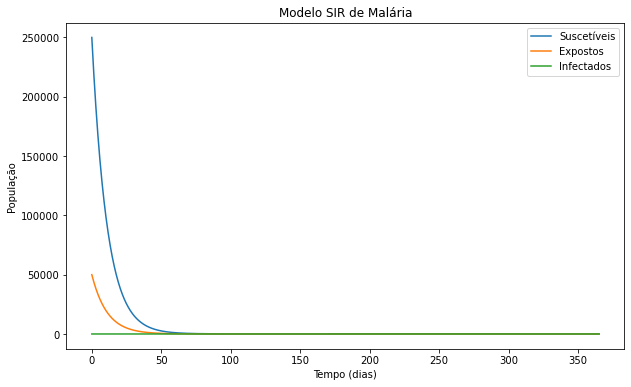

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [57]:
def lotkavolterra(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, T_linha, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T_linha) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    #dShdt = -a_curr * b2 * (I_M / N) * S_H
    #dIhdt = a_curr * b2 * (I_M(t - tau_H) / N) * S_H(t - tau_H) - gamma * I_H
    #dRhdt = gamma * I_H
    
    #dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu * S_M
    #dEmdt = a_curr * b1 * (I_H / N) * S_M - mu * E_M - a * b1 * (I_H(t - tau_H) / N) * S_M(t - tau_H) * l_tau_M
    #dImdt = a * b1 * (I_H(t - tau_H) / N) * S_M(t - tau_H) * l_tau_M - mu * I_M
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [58]:
T1=27.4
T2=0.025
omega1=0.02
phi1=1.53
R1=146.9
R2=0.033
omega2=0.02
phi2=1.99

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=36.5
b1=0.1

A=-0.03
B=1.31
C=-2.4

T_linha = 27.4
b2=0.3
tau_H=10
DD=105
Tmin=14.5
gamma= 1/1095 #1/365
R_L = 200
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

In [59]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, T_linha, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 269
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff1445fa50>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

In [60]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

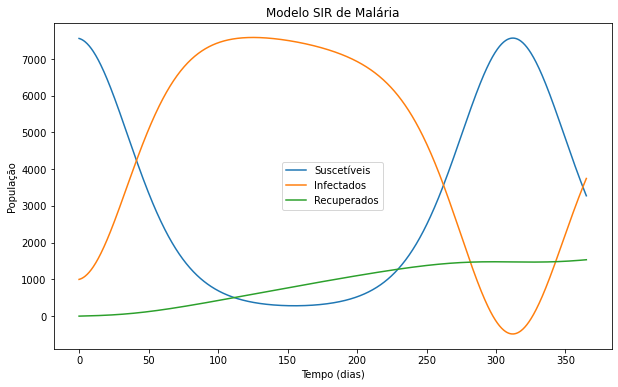

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [62]:
T_linha = 19.9

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, T_linha, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 545
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x6fff13d90e50>
   status: 0
  success: True
        t: array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
   

In [63]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

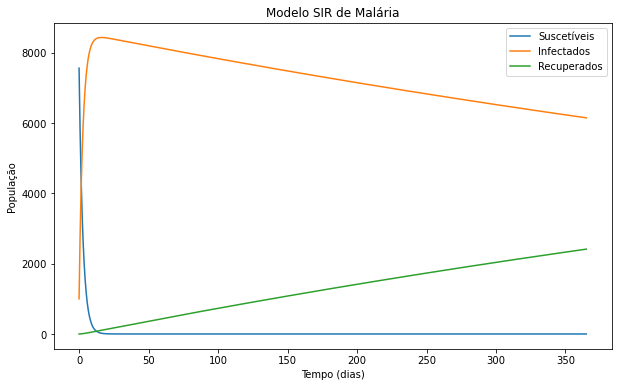

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()